## DESAFIO P&D (Machine Learning) Intelivix

### Este desafio consiste em realizar uma análise de sentimentos em  textos opinativos sobre filmes .



In [211]:
%matplotlib inline

import nltk
import string
import numpy as np
import pandas as pd

from nltk.corpus import stopwords
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from nltk.tokenize import word_tokenize
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\taiane.v.carvalho\AppData\Roaming\nltk_data..
[nltk_data]     .
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\taiane.v.carvalho\AppData\Roaming\nltk_data..
[nltk_data]     .
[nltk_data]   Package wordnet is already up-to-date!


True

## Conjunto de dados 

É feita a leitura dos dados e a exibição das informações que o mesmo possue. 

In [54]:
df_train = pd.read_csv('./dados/train.tsv', delimiter='\t',encoding='utf-8')

In [55]:
df_train.head()

,Id,IdSentenca,Texto,Sentimento
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


##### A coluna 'Id' tem o mesmo valor do 'Index' do Dataframe, então será removida.

In [56]:
del df_train['Id']

##### Cada texto possue um 'IdSentenca', a seguir  'IdSentenca' igual a 3.

In [57]:
df_train[df_train.IdSentenca == 3]

,IdSentenca,Texto,Sentimento
81,3,"Even fans of Ismail Merchant 's work , I suspe...",1
82,3,Even fans of Ismail Merchant 's work,2
83,3,Even fans,2
84,3,Even,2
85,3,fans,3
86,3,of Ismail Merchant 's work,2
87,3,Ismail Merchant 's work,2
88,3,Ismail Merchant 's,2
89,3,Ismail,2
90,3,Merchant 's,2


##### A função info() mostra algumas informções sobre o conjunt de dados

* Total de dados no geral (156.060)
* Total de dados não nulos em cada coluna e o tipo do dado 

In [134]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156060 entries, 0 to 156059
Data columns (total 3 columns):
IdSentenca    156060 non-null int64
Texto         156060 non-null object
Sentimento    156060 non-null int64
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


#### A base de dados possue 5 classes: Negativo - 0, um pouco negativo - 1, neutro - 2, um pouco positivo - 3 e positivo - 4. 
* Distribuiçao dos dados 

In [135]:
df_train.Sentimento.value_counts()

2    79582
3    32927
1    27273
4     9206
0     7072
Name: Sentimento, dtype: int64

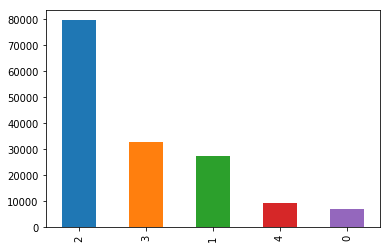

In [136]:
df_train.Sentimento.value_counts().plot(kind='bar')

## Pré-processamento

### A etapa de pré-processamento consistiu  em:

* Textos todo em minúsculo utilizando a função lower();
* Remoção de StopWords, menos as palavras 'no' e 'not' que podem ser significativas para a classificação da análise de sentimento;
* Uso da técnica de Stemming para reduzir as palavras até a sua base (stem). Assim, é possível tratar as palavras originais e suas respectivas derivações de uma mesma maneira;
* Remoção de números utilizando a função isdigit(); 
* Remoção de pontuações utilizando ponctuation da biblioteca string.

Para as etapas de remoção de StopWords e Stemming é necessário tokenizar as palavras. Primeiramente, foi realizado um split() nas palavras antes da formatação mas foi observado que no split palavras do tipo "I'm" não se separavavam, então o 'split' foi substituido pelo 'word_tokenize'.

In [137]:
not_remove = ['not', 'no']
stopwords_remove = set(stopwords.words('english')).difference(not_remove)
ps = PorterStemmer()

In [138]:
def format_text(X):
    X = [x.lower() for x in X]
    teste = [' '.join(word for word in word_tokenize(review) if word not in stopwords_remove) for review in X]
    teste = [' '.join([ps.stem(word) for word in word_tokenize(review)]) for review in teste]
    X = [''.join(i for i in s if not i.isdigit()) for s in teste]    
    X = [''.join(c for c in s if c not in string.punctuation) for s in teste]
    
    return X

#### Para realizar a formatação nos textos, eles foram extraídos do dataframe junto com a classificação e o 'Id_sentence'

In [139]:
X = df_train['Texto'].values.tolist()
Y = df_train['Sentimento'].values.tolist()
Id = df_train['IdSentenca'].values.tolist()

In [140]:
X = format_text(X)

#### Com os textos formatados foi montado um novo dataframe

In [141]:
dados = {'IdSentenca': Id, 'Texto': X, 'Sentimento': Y}

In [142]:
df = pd.DataFrame(dados)

In [143]:
df.head()

,IdSentenca,Texto,Sentimento
0,1,seri escapad demonstr adag good goos also good...,1
1,1,seri escapad demonstr adag good goos,2
2,1,seri,2
3,1,,2
4,1,seri,2


#### Após a formatação, alguns dados foram completamente removidos e se torna necessário excluir os espaços nulos.

In [144]:
df = df[df.Texto != '']

#### Os espaçamentos antes e depois nos textos também foram removidos, usando a função strip(), para comparações futuras

In [146]:
df['Texto'] = df['Texto'].str.strip()

In [147]:
df

,IdSentenca,Texto,Sentimento
0,1,seri escapad demonstr adag good goos also good...,1
1,1,seri escapad demonstr adag good goos,2
2,1,seri,2
4,1,seri,2
5,1,escapad demonstr adag good goos,2
7,1,escapad demonstr adag good goos,2
8,1,escapad,2
9,1,demonstr adag good goos,2
10,1,demonstr adag,2
11,1,demonstr,2


#### Observando os dados após o pre-processamento é notável que alguns ficaram repetidos. Então foi utilizada a função  'drop_duplicates' para remover os dados repetidos, mantendo a primeira ocorrência.

In [148]:
df = df.drop_duplicates(subset='Texto', keep='first')

In [149]:
df.head()

,IdSentenca,Texto,Sentimento
0,1,seri escapad demonstr adag good goos also good...,1
1,1,seri escapad demonstr adag good goos,2
2,1,seri,2
5,1,escapad demonstr adag good goos,2
8,1,escapad,2


In [150]:
df[df['IdSentenca'] == 3]

,IdSentenca,Texto,Sentimento
81,3,even fan ismail merchant s work suspect woul...,1
82,3,even fan ismail merchant s work,2
83,3,even fan,2
84,3,even,2
85,3,fan,3
86,3,ismail merchant s work,2
88,3,ismail merchant s,2
89,3,ismail,2
90,3,merchant s,2
91,3,merchant,2


#### Dados com o tamamnho menor que 1 foram removidos da base

In [152]:
df = df[df['Texto'].apply(lambda x: len(x) > 2)]

In [153]:
df[df['IdSentenca'] == 3]

,IdSentenca,Texto,Sentimento
81,3,even fan ismail merchant s work suspect woul...,1
82,3,even fan ismail merchant s work,2
83,3,even fan,2
84,3,even,2
85,3,fan,3
86,3,ismail merchant s work,2
88,3,ismail merchant s,2
89,3,ismail,2
90,3,merchant s,2
91,3,merchant,2


In [154]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82678 entries, 0 to 156059
Data columns (total 3 columns):
IdSentenca    82678 non-null int64
Texto         82678 non-null object
Sentimento    82678 non-null int64
dtypes: int64(2), object(1)
memory usage: 2.5+ MB


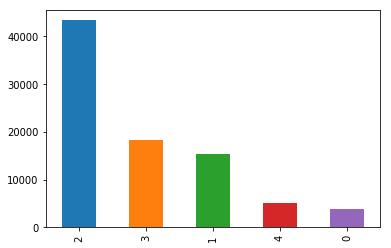

In [213]:
df.Sentimento.value_counts().plot(kind='bar')

In [155]:
X_train = df['Texto'].values.tolist()
Y_train = df['Sentimento'].values.tolist()

## Modelos de Classificação

Para essa análise serão utilizados os métodos:

* Máquina de Vetor de Suporte (Linear CSV)
* Naive Bayes
* Regressão Logística

Para analisar a solução do melhor modelo foi utilizado o método GridSearchCV que permite avaliar e selecionar sistematicamente os parâmetros de um modelo. Indicando um modelo e os parâmetros a serem testados, é possível avaliar o desempenho do primeiro em função dos segundos por meio de validação cruzada. 

Na validação cruzada, o conjunto de dados de treinamento é dividido em grupos de tamanho igual. Depois que a partição é feita, o modelo é treinado uma vez para cada um dos grupos. Usando todos os grupos, exceto o da iteração para treinar e esse para validar os resultados. 

No pipeline além do método de classificação/regressão foi utilizada a técnica 'TfidfVectorizer' do sklearn. 

O método tf-idf tem o intuito de indicar a importância de uma palavra em relação ao conjunto de dados. O valor tf–idf de uma palavra aumenta proporcionalmente à medida que aumenta o número de ocorrências dela em um exemplo, mas esse valor é equilibrado pela frequência da palavra em todo o conjunto de dados, ou seja, um termo ocorrendo frequentemente em poucos documentos tem um peso alto enquanto um termo que ocorre frequentemente em muitos documentos tem um peso baixo.



### LinearCSV com TFIDF

In [158]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LinearSVC()),
])

param_grid= {
    'tfidf__sublinear_tf':[True, False],
    'tfidf__max_df': [0.1, 0.2, 0.3, 0.5, 0.7],
    'tfidf__ngram_range': [(1,1), (1,2), (1,3), (1,4)],
    'clf__C':[0.1,1.0]   
}

In [160]:
grid = GridSearchCV(pipeline, cv=5, param_grid=param_grid)
grid.fit(X_train,Y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('tfidf',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                         

In [161]:
means1stem = grid.cv_results_['mean_test_score']
means1stem

array([0.56602724, 0.56623286, 0.56228985, 0.56222937, 0.5601853 ,
       0.56037882, 0.55925397, 0.5594354 , 0.56602724, 0.56623286,
       0.56228985, 0.56222937, 0.5601853 , 0.56037882, 0.55925397,
       0.5594354 , 0.56602724, 0.56623286, 0.56228985, 0.56222937,
       0.5601853 , 0.56037882, 0.55925397, 0.5594354 , 0.56602724,
       0.56622076, 0.56228985, 0.56222937, 0.5601853 , 0.56037882,
       0.55925397, 0.5594354 , 0.56602724, 0.56623286, 0.56228985,
       0.56222937, 0.5601853 , 0.56037882, 0.55925397, 0.5594354 ,
       0.55289194, 0.55278309, 0.54105082, 0.5408694 , 0.54005902,
       0.53991388, 0.54003483, 0.54008321, 0.55289194, 0.55277099,
       0.54103873, 0.5408694 , 0.54005902, 0.53991388, 0.54003483,
       0.54008321, 0.55289194, 0.55277099, 0.54103873, 0.5408694 ,
       0.54005902, 0.53991388, 0.54003483, 0.54008321, 0.55289194,
       0.55277099, 0.54103873, 0.5408694 , 0.54005902, 0.53991388,
       0.54003483, 0.54008321, 0.55289194, 0.55277099, 0.54103

In [162]:
means1stem.mean()

0.5527310771910303

In [163]:
grid.best_params_

{'clf__C': 0.1,
 'tfidf__max_df': 0.1,
 'tfidf__ngram_range': (1, 1),
 'tfidf__sublinear_tf': False}

### LogisticRegression com TFIDF

In [164]:
pipeline2 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression())
])

param_grid2= {
    'tfidf__sublinear_tf':[True, False],
    'tfidf__max_df': [0.1, 0.2, 0.3, 0.5, 0.7],
    'tfidf__ngram_range': [(1,1), (1,2), (1,3), (1,4)]}

In [165]:
grid2 = GridSearchCV(pipeline2, cv=5, param_grid=param_grid2)
grid2.fit(X_train,Y_train)

C:\Users\taiane.v.carvalho\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\taiane.v.carvalho\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('tfidf',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                         

In [166]:
means2stem = grid2.cv_results_['mean_test_score']

In [189]:
means2stem.mean()

0.5616472943225526

In [168]:
grid2.best_params_

{'tfidf__max_df': 0.1,
 'tfidf__ngram_range': (1, 1),
 'tfidf__sublinear_tf': True}

### MultinomialNB com TFIDF

In [169]:
pipeline3 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB()),
])

param_grid3 = {
    'tfidf__sublinear_tf':[True, False],
    'tfidf__max_df': [10, 20, 30, 40 ,50, 60, 70, 80, 90],
    'tfidf__ngram_range': [(1,1), (1,2), (1,3), (1,4)],   
    'clf__alpha': [1, 0.1, 0.01, 0.001] 
}

grid3 = GridSearchCV(pipeline3, cv=5, param_grid=param_grid3)
grid3.fit(X,Y)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('tfidf',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                         

In [170]:
means3stem = grid3.cv_results_['mean_test_score']

In [171]:
means3stem.mean()

0.49378461987554645

In [172]:
grid3.best_params_

{'clf__alpha': 1,
 'tfidf__max_df': 90,
 'tfidf__ngram_range': (1, 1),
 'tfidf__sublinear_tf': True}

### Foram realizados testes com Lemmatization ao invés do Stemming para comparação dos resultados. 

A lematização, ao contrário do Stemming, reduz as palavras flexionadas garantindo adequadamente que a palavra raiz pertence à linguagem (continua compreensível). Na lematização, a palavra raiz é chamada de Lemma. Um lemma é a forma canônica, a forma de dicionário ou a forma de citação de um conjunto de palavras. A técniva 'WordNetLemmatizer' foi utilizada para realizar esse processo.

O restante do pré-processamento permaneceu igual ao feito anteriormente.

In [173]:
lemmatizer = WordNetLemmatizer()

In [174]:
def format_text2(X):
    X = [x.lower() for x in X]
    teste = [' '.join(word for word in word_tokenize(review) if word not in stopwords_remove) for review in X]
    teste = [' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(review)]) for review in teste]
    X = [''.join(i for i in s if not i.isdigit()) for s in teste]    
    X = [''.join(c for c in s if c not in string.punctuation) for s in teste]
    
    return X

In [175]:
X = df_train['Texto'].values.tolist()
X = format_text2(X)
dados = {'IdSentenca': Id, 'Texto': X, 'Sentimento': Y}

In [176]:
df = pd.DataFrame(dados)
df = df[df.Texto != '']
df['Texto'] = df['Texto'].str.strip()
df = df.drop_duplicates(subset='Texto', keep='first')
df = df[df['Texto'].apply(lambda x: len(x) > 2)]

In [177]:
df.head()

,IdSentenca,Texto,Sentimento
0,1,series escapade demonstrating adage good goose...,1
1,1,series escapade demonstrating adage good goose,2
2,1,series,2
5,1,escapade demonstrating adage good goose,2
8,1,escapade,2


In [178]:
X_train = df['Texto'].values.tolist()
Y_train = df['Sentimento'].values.tolist()

### Os gridsearchs dos diferentes métodos definidos na etapa anterior foram utilizados para o novo conjunto de dados

### LinearCSV com TFIDF

In [179]:
grid.fit(X_train,Y_train)
means1lemma = grid.cv_results_['mean_test_score']
grid.best_params_

{'clf__C': 0.1,
 'tfidf__max_df': 0.1,
 'tfidf__ngram_range': (1, 1),
 'tfidf__sublinear_tf': False}

In [181]:
means1lemma.mean()

0.5544832623320997

### LogisticRegression com TFIDF

In [182]:
grid2.fit(X_train,Y_train)
means2lemma = grid2.cv_results_['mean_test_score']
grid2.best_params_

C:\Users\taiane.v.carvalho\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\taiane.v.carvalho\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


{'tfidf__max_df': 0.1,
 'tfidf__ngram_range': (1, 1),
 'tfidf__sublinear_tf': True}

In [188]:
means2lemma.mean()

0.5623676001582979

### MultinomialNB com TFIDF

In [185]:
grid3.fit(X_train,Y_train)
means3lemma = grid3.cv_results_['mean_test_score']
grid3.best_params_

{'clf__alpha': 1,
 'tfidf__max_df': 90,
 'tfidf__ngram_range': (1, 1),
 'tfidf__sublinear_tf': True}

In [187]:
means3lemma.mean()

0.4805190364783388

## Modelo Final

O modelo que apresentou um melhor desempenho foi o LogisticRegression com Lemmatization no pré-processamento e ele será testado com os melhores parâmetros segundo o GridSearch realizado.

O método KFold é responsável por dividir o conjunto de dados em n partes e realizar o treinamento e teste com cada um deles. Isso permite que o conjunto de testes escolhido não seja uma amostra  ruim ou muito boa e enviese a análise do resultado da classificação. 

In [208]:
kf = KFold(n_splits=5)
accuracy = []
for train_index, test_index in kf.split(X_train):    
    
    X_train_, X_test_ = [X_train[index] for index in train_index], [X_train[index] for index in test_index]
    y_train_, y_test_ = [Y_train[index] for index in train_index], [Y_train[index] for index in test_index]
    
    
    vectorizer = TfidfVectorizer(sublinear_tf= True, max_df=0.1, ngram_range=(1,1))
    X_train_transformed = vectorizer.fit_transform(X_train_)
   
    clf = LogisticRegression()
    clf.fit(X_train_transformed, y_train_)
    
    X_teste_transformed = vectorizer.transform(X_test_)
    predict = clf.predict(X_teste_transformed)
    
    accuracy.append(accuracy_score(y_test_,predict))
    print(classification_report(y_test_,predict))



              precision    recall  f1-score   support

           0       0.58      0.06      0.11       603
           1       0.47      0.22      0.29      2776
           2       0.65      0.90      0.76      9524
           3       0.49      0.34      0.40      3414
           4       0.57      0.16      0.25       866

    accuracy                           0.61     17183
   macro avg       0.55      0.34      0.36     17183
weighted avg       0.58      0.61      0.56     17183

              precision    recall  f1-score   support

           0       0.42      0.05      0.09       821
           1       0.42      0.22      0.29      2942
           2       0.60      0.89      0.72      8580
           3       0.50      0.35      0.41      3799
           4       0.54      0.13      0.21      1041

    accuracy                           0.57     17183
   macro avg       0.50      0.33      0.34     17183
weighted avg       0.54      0.57      0.52     17183

              precisio

#### O valor médio de acurácia para o modelo é de:

In [212]:
np.mean(accuracy)

0.5740622553226544

## Considerações finais

Os dados de sentimento não estavam balanceados, como pode ser visto nos gráficos mostrados no início. Observando o resultado, é possível notar que quanto mais dados a classe possui, melhor o resultado do treinamento.  Um balanceamento dos dados poderia apresentar uma possível melhora nos resultados.